In [1]:
import os
from pathlib import Path 
import json
from dataclasses import dataclass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from coqstoq import get_theorem_list, Split
from coqstoq.check import Result

In [2]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling":
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [3]:

@dataclass
class NamedDF:
    name: str
    df: pd.DataFrame

def load_results(p: Path, sysname: str, timeout: int = 600) -> NamedDF:
    rows = [] 
    for r_path in p.glob("**/*.json"):
        with r_path.open() as f:
            r_data = json.load(f)
            result = Result.from_json(r_data)
            rows.append({
                "project": result.thm.project.workspace.name, 
                "path": result.thm.path,
                "line": result.thm.theorem_start_pos.line,
                "success": result.proof is not None and result.time < timeout,
                "time": result.time,
            })
    df = pd.DataFrame(rows)
    return NamedDF(sysname, df.set_index(["project", "path", "line"]))

def create_joint_eval(df1: NamedDF, df2: NamedDF, normalize: bool=True, timeout: int=600) -> NamedDF:
    if normalize:
        new_name = f"Adjusted {df1.name} + {df2.name}"
    else:
        new_name = f"Unadjusted {df1.name} + {df2.name}"
    merged_df = df1.df.merge(df2.df, left_index=True, right_index=True, suffixes=("_1", "_2"))
    if normalize:
        merged_df["time"] = merged_df.apply(lambda row: min(row["time_1"], row["time_2"]) * 2, axis=1)
    else:
        merged_df["time"] = merged_df.apply(lambda row: min(row["time_1"], row["time_2"]), axis=1)
    merged_df["success"] = (merged_df["success_1"] | merged_df["success_2"]) & (merged_df["time"] < timeout)
    return NamedDF(new_name, merged_df[["success", "time"]])


def filter_df(named_df: NamedDF, idx : pd.Index) -> NamedDF:
    return NamedDF(named_df.name, named_df.df.loc[idx])


def mk_time_plot(ndfs: list[NamedDF], timeout: int = 600): 
    fig, ax = plt.subplots()
    for ndf in ndfs:
        success_df = ndf.df.loc[ndf.df["success"]]
        by_time = success_df.sort_values("time")
        successes = list(np.arange(len(by_time)) + 1) + [len(by_time)]
        ax.plot(by_time["time"] + [timeout], np.arange(len(by_time)) + 1, label=ndf.name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Theorems Proven")
    ax.set_title("# Theorems Proven over Time")
    ax.legend()
    

def get_by_project_summary(named_df: NamedDF) -> pd.DataFrame:
    return named_df.df.groupby("project").agg(
        RATE=("success", "mean"), 
        SUCCESSES=("success", "sum"), 
        TOTAL=("success", "count")
    ).sort_values("TOTAL", ascending=False)


def get_totals(named_df: NamedDF) -> pd.Series:
    n_df = NamedDF(named_df.name, named_df.df.agg(
        RATE=("success", "mean"), 
        SUCCESSES=("success", "sum"), 
        TOTAL=("success", "count")
    ))
    series = n_df.df["success"]
    series.name = named_df.name
    return series

## Ablations (CoqStoq 0-499)

In [7]:
RANGO_RESULT = load_results(Path("evaluations/coqstoq-results/test-rango"), "Rango")

In [8]:
RANGO_NO_LEMMA = load_results(Path("evaluations/coqstoq-results/test-abl-no-lemma"), "Rango w/o Lemmas")
RANGO_NO_PROOF = load_results(Path("evaluations/coqstoq-results/test-abl-no-proof"), "Rango w/o Proofs")
RANGO_NO_RETRIEVAL = load_results(Path("evaluations/coqstoq-results/test-abl-no-retrieval"), "Rango w/o Proofs and Lemmas")
# RANGO_FIRST_STEP = load_results(Path("evaluations/coqstoq-results/test-abl-first-step"), "first-step")
# PREFIX = load_results(Path("evaluations/coqstoq-results/test-abl-prefix"), "Rango w/ Prefix Retrieval")
# TFIDF_PROOF = load_results(Path("evaluations/coqstoq-results/test-abl-tfidf-proof"), "tfidf-proof")
# BM25_LEMMA = load_results(Path("evaluations/coqstoq-results/test-abl-bm25-lemma"), "bm25-lemma") 

ABL_RESULTS = [
    RANGO_NO_LEMMA,
    RANGO_NO_PROOF,
    RANGO_NO_RETRIEVAL,
]

In [10]:
assert 0 < len(ABL_RESULTS)
filtered_rango = filter_df(RANGO_RESULT, ABL_RESULTS[0].df.index)
rango_total = get_totals(filtered_rango)
abl_totals = [get_totals(r) for r in ABL_RESULTS]
pd.concat([rango_total] + abl_totals, axis=1)

,Rango,Rango w/o Lemmas,Rango w/o Proofs,Rango w/o Proofs and Lemmas
RATE,0.3,0.29,0.204,0.186
SUCCESSES,150.0,145.00,102.000,93.000
TOTAL,500.0,500.00,500.000,500.000


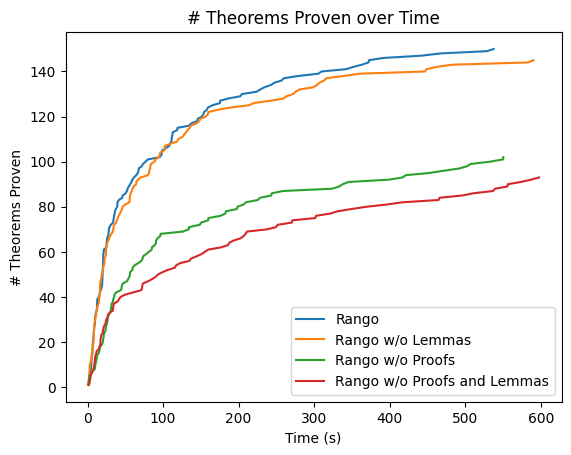

In [11]:
mk_time_plot([filtered_rango, RANGO_NO_LEMMA, RANGO_NO_PROOF, RANGO_NO_RETRIEVAL])

In [28]:
filtered_tactician = filter_df(TACTICIAN_RESULT, ABL_RESULTS[0].df.index)
get_totals(create_joint_eval(filtered_tactician, PREFIX))

RATE           0.356
SUCCESSES    178.000
TOTAL        500.000
Name: tactitian + Rango w/ Prefix Retrieval, dtype: float64

In [29]:
get_totals(create_joint_eval(filtered_tactician, filtered_rango))

RATE           0.354
SUCCESSES    177.000
TOTAL        500.000
Name: tactitian + Rango, dtype: float64

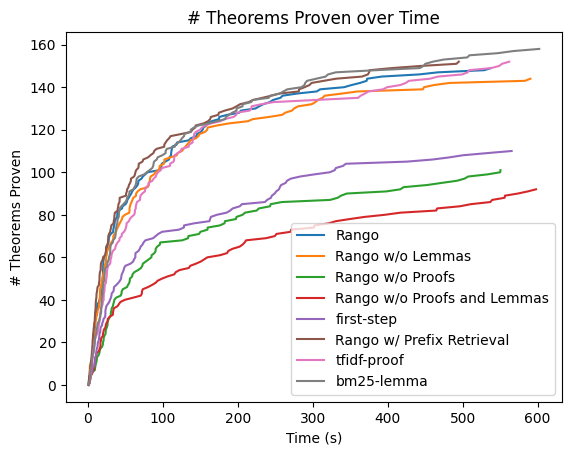

In [30]:
mk_time_plot([filtered_rango, *ABL_RESULTS])

In [31]:
get_totals(create_joint_eval(filtered_rango, TFIDF_PROOF))

RATE           0.338
SUCCESSES    169.000
TOTAL        500.000
Name: Rango + tfidf-proof, dtype: float64

In [32]:
get_totals(create_joint_eval(filtered_rango, BM25_LEMMA))

RATE           0.342
SUCCESSES    171.000
TOTAL        500.000
Name: Rango + bm25-lemma, dtype: float64

## Cross-Tool Comparison (Cutoff)

In [4]:
RANGO_RESULT = load_results(Path("evaluations/coqstoq-results/cutoff-rango"), "rango")
PREFIX_RESULT = load_results(Path("evaluations/coqstoq-results/cutoff-prefix"), "prefix")
# TACTICIAN_RESULT = load_results(Path("evaluations/coqstoq-results/cutoff-tactician"), "tactitian")
PROVERBOT_RESULT = load_results(Path("evaluations/coqstoq-results/cutoff-proverbot"), "proverbot")

In [5]:
get_by_project_summary(PREFIX_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
pnvrocqlib,0.249249,166,666
bb5,0.365751,173,473


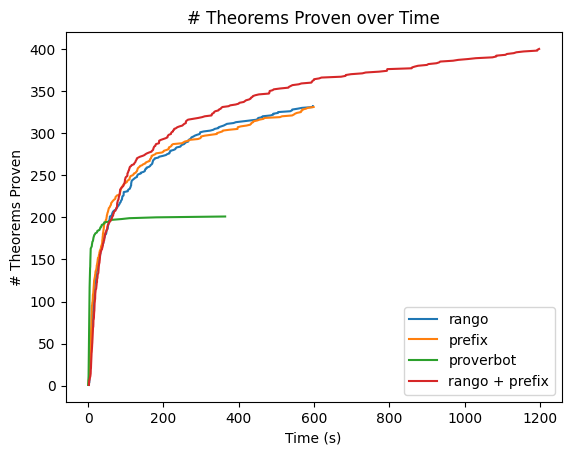

In [6]:
PREFIX_RESULT_NO_INCOMPLETE = NamedDF("prefix", PREFIX_RESULT.df.dropna())
RANGO_RESULT_NO_INCOMPLETE = NamedDF("rango", RANGO_RESULT.df.dropna())
intersection_idx = PREFIX_RESULT_NO_INCOMPLETE.df.index.intersection(RANGO_RESULT_NO_INCOMPLETE.df.index) 
filtered_rango = filter_df(RANGO_RESULT, intersection_idx)
filtered_proverbot = filter_df(PROVERBOT_RESULT, intersection_idx)
filtered_prefix = filter_df(PREFIX_RESULT, intersection_idx)
joint_eval = create_joint_eval(filtered_rango, filtered_prefix)

mk_time_plot([filtered_rango, filtered_prefix, filtered_proverbot, joint_eval])

In [7]:
get_by_project_summary(filtered_rango)

,RATE,SUCCESSES,TOTAL
project,,,
pnvrocqlib,0.251185,159,633
bb5,0.400463,173,432


In [10]:
get_by_project_summary(filtered_prefix)

,RATE,SUCCESSES,TOTAL
project,,,
pnvrocqlib,0.255924,162,633
bb5,0.391204,169,432


In [9]:
get_by_project_summary(filtered_rango)

,RATE,SUCCESSES,TOTAL
project,,,
pnvrocqlib,0.251185,159,633
bb5,0.400463,173,432


In [8]:
get_by_project_summary(TACTICIAN_RESULT)

NameError: name 'TACTICIAN_RESULT' is not defined

In [9]:
get_totals(TACTICIAN_RESULT)

NameError: name 'TACTICIAN_RESULT' is not defined

In [35]:
get_by_project_summary(PROVERBOT_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
pnvrocqlib,0.164244,113,688
bb5,0.215321,104,483


In [36]:
get_totals(PROVERBOT_RESULT)

RATE            0.185312
SUCCESSES     217.000000
TOTAL        1171.000000
Name: proverbot, dtype: float64

## Cross-Tool Comparison (Graph2Tac)

In [6]:
RANGO_RESULT = load_results(Path("evaluations/coqstoq-results/test-rango"), "rango")
GRAPH2TAC_RESULT = load_results(Path("evaluations/coqstoq-results/test-graph2tac"), "graph2tac")

In [7]:
filtered_rango = filter_df(RANGO_RESULT, GRAPH2TAC_RESULT.df.index)

In [8]:
get_by_project_summary(filtered_rango)

,RATE,SUCCESSES,TOTAL
project,,,
zfc,0.362319,75,207
poltac,0.835526,127,152
dblib,0.540146,74,137


In [9]:
get_by_project_summary(GRAPH2TAC_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
zfc,0.285024,59,207
poltac,0.907895,138,152
dblib,0.496350,68,137


In [11]:
get_totals(filtered_rango)

RATE           0.556452
SUCCESSES    276.000000
TOTAL        496.000000
Name: rango, dtype: float64

In [10]:
get_totals(GRAPH2TAC_RESULT)

RATE           0.534274
SUCCESSES    265.000000
TOTAL        496.000000
Name: graph2tac, dtype: float64

## Cross-Tool Comparison (Test)

In [4]:
RANGO_RESULT = load_results(Path("evaluations/coqstoq-results/test-rango"), "rango")
# TACTICIAN_RESULT = load_results(Path("evaluations/coqstoq-results/test-tactician"), "tactitian")
# PREFIX_RESULT = load_results(Path("evaluations/coqstoq-results/test-abl-prefix"), "prefix")
PROVERBOT_RESULT = load_results(Path("evaluations/coqstoq-results/test-proverbot"), "proverbot")
# ORIG_RANGO_RESULT = load_results(Path("evaluations/coqstoq-results/test-orig-rango"), "rango (tfidf proof, tfidf prem)")

In [5]:
get_by_project_summary(PROVERBOT_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
compcert,0.214544,1304,6078
fourcolor,0.099402,133,1338
math-classes,0.128440,98,763
buchberger,0.156535,103,658
reglang,0.091195,29,318
poltac,0.540541,140,259
huffman,0.183594,47,256
zfc,0.178744,37,207
zorns-lemma,0.125714,22,175


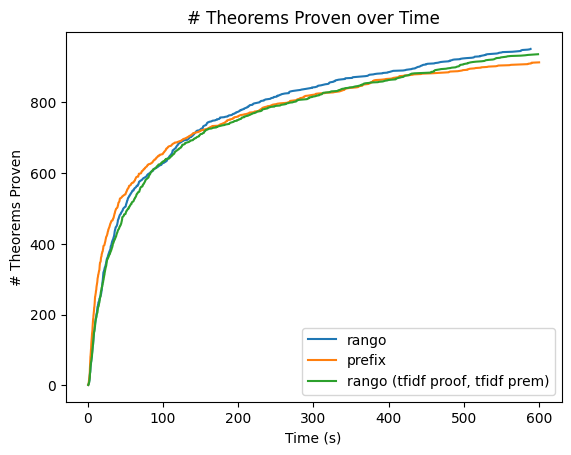

In [19]:
mutual_idx = RANGO_RESULT.df.index.intersection(PREFIX_RESULT.df.index).intersection(ORIG_RANGO_RESULT.df.index)
filtered_rango = filter_df(RANGO_RESULT, mutual_idx)
filtered_prefix = filter_df(PREFIX_RESULT, mutual_idx)
filtered_orig_rango = filter_df(ORIG_RANGO_RESULT, mutual_idx)
mk_time_plot([filtered_rango, filtered_prefix, filtered_orig_rango])


# mutual_idx = RANGO_RESULT.df.index.intersection(PREFIX_RESULT.df.index)
# filtered_rango = filter_df(RANGO_RESULT, mutual_idx)
# filtered_prefix = filter_df(PREFIX_RESULT, mutual_idx)
# joint_eval = create_joint_eval(filtered_rango, filtered_prefix)
# # joint_eval = create_joint_eval(filtered_rango, filtered_prefix, normalize=False)
# mk_time_plot([filtered_rango, filtered_prefix, joint_eval])

In [12]:
get_totals(filtered_rango)

RATE            0.321325
SUCCESSES    3202.000000
TOTAL        9965.000000
Name: rango, dtype: float64

In [13]:
get_totals(filtered_prefix)

RATE            0.315605
SUCCESSES    3145.000000
TOTAL        9965.000000
Name: prefix, dtype: float64

In [8]:
PROVERBOT_RESULT = load_results(Path("evaluations/coqstoq-results/test-proverbot"), "proverbot")

In [9]:
get_by_project_summary(RANGO_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
compcert,0.325562,1983,6091
fourcolor,0.158091,212,1341
math-classes,0.397117,303,763
buchberger,0.273556,180,658
reglang,0.132075,42,318
poltac,0.833977,216,259
huffman,0.320312,82,256
zfc,0.362319,75,207
zorns-lemma,0.291429,51,175


In [10]:
get_by_project_summary(RANGO_RESULT)

,RATE,SUCCESSES,TOTAL
project,,,
compcert,0.325562,1983,6091
fourcolor,0.158091,212,1341
math-classes,0.397117,303,763
buchberger,0.273556,180,658
reglang,0.132075,42,318
poltac,0.833977,216,259
huffman,0.320312,82,256
zfc,0.362319,75,207
zorns-lemma,0.291429,51,175


In [11]:
get_totals(TACTICIAN_RESULT)

RATE             0.202866
SUCCESSES     2109.000000
TOTAL        10396.000000
Name: tactitian, dtype: float64

In [12]:
get_totals(RANGO_RESULT)

RATE             0.320412
SUCCESSES     3331.000000
TOTAL        10396.000000
Name: rango, dtype: float64